# Predicting Lung Cancer Survival.

##### Pooja Patel, Eli Parker, Christopher Wilhite

#### This is the preproccessing data for the test dataset. 

### Importing the Packages. 

Importing matplotlib for visualization and pandas for reading the csv and cleaning.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import re # regular expressions, using this to trim the column names 
import csv
import numpy as np
from lifelines import CoxPHFitter

### Understanding and Visualizing the test data. 

Variables in the Clinical Data. 

* **Patient Id:** Numbered Patient. 
* **Age:** The age of the Patient. 
* **Histology:** type of cancer cell presented within the patient.
* **Tstage:** determines how much and where the cancer is in the body. The numbers(1-4) describes the tumor size and/or the amount of spread into nearby structures. 0 means there is no evidance of primary tumor.
* **Nstage:** tells weather the cancer has spread to the nearby lymph nodes. The numbers(1-3) describe the size, location, and/or the number of nearby lymph nodes affected by cancer. 0 means nearby lymph nodes do not contain cancer. 
* **Mstage:** tells weather the cancer has spread to distant parts of the body. 0 means no distant cancer has been found. 1 means cancer has been found to have spread to distant organs or tissue. 
* **SourceDataset:**  location where data that is being used originates from

to start the data analysis we read in the clinical data csv and display part of the data.

In [2]:
df = pd.read_csv('x test(9c)/clinical_data.csv')
df.head(20)

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
0,13,nos,0,0,l1,4,44.3970
1,155,adenocarcinoma,0,3,l1,1,63.3183
2,404,large cell,0,2,l1,2,64.7255
3,407,nos,0,0,l1,2,65.3635
4,9,Adenocarcinoma,0,0,l2,2,50.0000
5,49,squamous cell carcinoma,0,0,l1,2,86.1410
6,55,NaN,0,0,l1,1,75.2663
7,200,NaN,0,0,l1,1,85.4511
8,170,large cell,0,3,l1,1,69.8727
9,387,large cell,0,3,l1,2,52.8569


The bar graph shows all the different cancer types included in this study against the number of cases that each type had. This graph shows that Adenocarcinoma was the type of cancer with the most recorded cases. This graph also includes the nan and the two types of NOS data that were collected. 

In [3]:
DeepnoteChart(df, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"Histology","scale":{"type":"linear"}},"y":{"sort":null,"type":"quantitative","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"count","formatType":"numberFormatFromNumberType"},"color":{"sort":null,"type":"nominal","field":"Histology","scale":{"scheme":"tableau10"}}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

First thing with this data frame, we want to see any upfront correlations between the variables, so we will make a matrix.

In [4]:
print(df.corr())

           PatientID    Mstage    Nstage    Tstage       age
PatientID   1.000000  0.101298  0.007647 -0.005751 -0.055499
Mstage      0.101298  1.000000 -0.110225 -0.030301  0.049887
Nstage      0.007647 -0.110225  1.000000  0.166456 -0.204202
Tstage     -0.005751 -0.030301  0.166456  1.000000 -0.075136
age        -0.055499  0.049887 -0.204202 -0.075136  1.000000


This matrix here makes no sense, as this suggests that as the age of cancer goes up, the N or T stage goes down. This does not make sense in the context of the progression of cancer.

Variables in the radiomics Data. 

Radiomics is a method for analyzing high-throughput imaging data and extracting a large number of sophisticated quantitative features. By using radiomics data we can obtain extremely valuable information about cancer that may have been overlooked or that cannot be identified with the naked eye. 

Some information about the 3 main categories that are under radiomics data. 
* shape 
    * describe the shape of the delineated ROI
    * shape descriptors are independent of gray value, and are extracted from the label mask. 
    * If enabled, they are calculated separately of enabled input image types, and listed in the result as if calculated on the original image.
* first order 
    * statistics of the voxel values
* textural 
    * obtained from voxel to neighbouring voxel relationships and provide information on voxel intensities and geometry.
    * grey level co-occurrence matrix (GLCM)
        * quantifies the number of voxels with the same intensities within a given range.
    * Grey-level run-length matrix (GLRLM), 
        * counts the number of consecutive voxels with the same intensity. 
* Some acronyms that are used multiples times in the dataset:
    * ROI: Region of Interest. 
    * GLCM: Gray-Level Co-Occurrence Matrix 
    * GLRLM: Gray Level Run Length Matrix. 

**Below is the description of the varibales in radiomics data**

* **shape: original_shape_Compactness1** measure of how compact the shape of the tumor is relative to a sphere (most compact)
* **shape: original_shape_Compactness2** measure of how compact the shape of the tumor is relative to a sphere (most compact)
* **shape: original_shape_Maximum3DDiameter** largest pairwise Euclidean distance between tumor surface mesh vertices.
* **shape: original_shape_SphericalDisproportion** ratio of the surface area of the tumor region to the surface area of a sphere with the same volume as the tumor region, and by definition, the inverse of Sphericity
* **shape: original_shape_Sphericity** measure of the roundness of the shape of the tumor region relative to a sphere
* **shape: original_shape_SurfaceAera** an approximation of the surface of the ROI in mm2, calculated using a marching cubes algorithm.
* **shape: original_shape_SurfaceVolumeRatio** a lower value indicates a more compact (sphere-like) shape. This feature is not dimensionless, and is therefore (partly) dependent on the volume of the ROI.
* **shape: original_shape_VoxelVolume** multiplying the number of voxels in the ROI by the volume of a single voxel
* **firstorder: original_firstorder_Energy** measure of the magnitude of voxel values in an image. A larger values implies a greater sum of the squares of these values.
* **firstorder: original_firstorder_Entropy** specifies the uncertainty/randomness in the image values. It measures the average amount of information required to encode the image values.
* **firstorder: original_firstorder_Kurtosis**   measure of the ‘peakedness’ of the distribution of values in the image ROI. A higher kurtosis implies that the mass of the distribution is concentrated towards the tail(s) rather than towards the mean. A lower kurtosis implies the reverse: that the mass of the distribution is concentrated towards a spike near the Mean value.
* **firstorder: original_firstorder_Maximum** maximum gray level intensity within the ROI.
* **firstorder: original_firstorder_Mean** average gray level intensity within the ROI.
* **firstorder: original_firstorder_MeanAbsoluteDeviation** mean distance of all intensity values from the Mean Value of the image array.
* **firstorder: original_firstorder_Median** median gray level intensity within the ROI.
* **firstorder: original_firstorder_Minimum** minimum gray level intensity within the ROI.
* **firstorder: original_firstorder_Range** range of gray values in the ROI.
* **firstorder: original_firstorder_RootMeanSquared** square-root of the mean of all the squared intensity values. It is another measure of the magnitude of the image values
* **firstorder: original_firstorder_Skewness** measures the asymmetry of the distribution of values about the Mean value. Depending on where the tail is elongated and the mass of the distribution is concentrated, this value can be positive or negative.
* **firstorder: original_firstorder_StandardDeviation** measures the amount of variation or dispersion from the Mean Value.
* **firstorder: original_firstorder_Uniformity** a measure of the sum of the squares of each intensity value. 
* **firstorder: original_firstorder_Variance** the the mean of the squared distances of each intensity value from the Mean value. This is a measure of the spread of the distribution about the mean.
* **textural: original_glcm_Autocorrelation** a measure of the magnitude of the fineness and coarseness of texture.
* **textural: original_glcm_ClusterProminence** a measure of the skewness and asymmetry of the GLCM. A higher values implies more asymmetry about the mean while a lower value indicates a peak near the mean value and less variation about the mean.
* **textural: original_glcm_ClusterShade** measure of the skewness and uniformity of the GLCM. A higher cluster shade implies greater asymmetry about the mean.
* **textural: original_glcm_ClusterTendency** measure of groupings of voxels with similar gray-level values.
* **textural: original_glcm_Contrast** a measure of the local intensity variation, favoring values away from the diagonal (𝑖=𝑗). A larger value correlates with a greater disparity in intensity values among neighboring voxels.
* **textural: original_glcm_Correlation** value between 0 (uncorrelated) and 1 (perfectly correlated) showing the linear dependency of gray level values to their respective voxels in the GLCM.
* **textural: original_glcm_DiffernceEntropy**  measure of the randomness/variability in neighborhood intensity value differences.
* **textural: original_glcm_DifferenceAverage** measures the relationship between occurrences of pairs with similar intensity values and occurrences of pairs with differing intensity values.
* **textural: original_glcm_JointEnergy** Energy is a measure of homogeneous patterns in the image. A greater Energy implies that there are more instances of intensity value pairs in the image that neighbor each other at higher frequencies.
* **textural: original_glcm_JointEntropy** measure of the randomness/variability in neighborhood intensity values.
* **textural: original_glcm_Id** Inverse Difference. Homogeneity 1 is another measure of the local homogeneity of an image.
* **textural: original_glcm_Idm** Inverse Difference Moment. Homogeneity 2 is a measure of the local homogeneity of an image
* **textural: original_glcm_Imc1** Informational Measure of Correlation1. assesses the correlation between the probability distributions of 𝑖 and 𝑗 (quantifying the complexity of the texture)
* **textural: original_glcm_Imc2** Informational Measure of Correlation2. also assesses the correlation between the probability distributions of 𝑖 and 𝑗 (quantifying the complexity of the texture).
* **textural: original_glcm_Idmn** Inverse Difference Moment Normalized. inverse difference moment normalized is a measure of the local homogeneity of an image. 
* **textural: original_glcm_Idn** Inverse Difference Normalized.  inverse difference normalized is another measure of the local homogeneity of an image. normalizes the difference between the neighboring intensity values by dividing over the total number of discrete intensity values.
* **textural: original_glcm_InverseVarience** method of aggregating two or more random varaibles to minimize the variance of the weighted average. 
* **textural: original_glcm_MaximumProbability** occurrences of the most predominant pair of neighboring intensity values.
* **textural: original_glcm_SumAverage** measures the relationship between occurrences of pairs with lower intensity values and occurrences of pairs with higher intensity values.
* **textural: original_glcm_SumEntropy** a sum of neighborhood intensity value differences.
* **textural: original_glrlm_ShortRunEmphasis**  measure of the distribution of short run lengths, with a greater value indicative of shorter run lengths and more fine textural textures.
* **textural: original_glrlm_LongRunEmphasis** measure of the distribution of long run lengths, with a greater value indicative of longer run lengths and more coarse structural textures.
* **textural: original_glrlm_GrayLevelNonUniformity** measures the similarity of gray-level intensity values in the image, where a lower GLN(Gray Level Non-Uniformity) value correlates with a greater similarity in intensity values.
* **textural: original_glrlm_RunLengthNonUniformity** (RLN) measures the similarity of run lengths throughout the image, with a lower value indicating more homogeneity among run lengths in the image.
* **textural: original_glrlm_RunPercentage** (RP) measures the coarseness of the texture by taking the ratio of number of runs and number of voxels in the ROI.
* **textural: original_glrlm_LowGrayLevelRunEmphasis** (LGLRE) measures the distribution of low gray-level values, with a higher value indicating a greater concentration of low gray-level values in the image.
* **textural: original_glrlm_HighGrayLevelRunEmphasis** (HGLRE) measures the distribution of the higher gray-level values, with a higher value indicating a greater concentration of high gray-level values in the image.
* **textural: original_glrlm_ShortRunLowGrayLevelEmphasis** (SRLGLE) measures the joint distribution of shorter run lengths with lower gray-level values.
* **textural: original_glrlm_ShortRunHighGrayLevelEmphasis** (SRHGLE) measures the joint distribution of shorter run lengths with higher gray-level values
* **textural: original_glrlm_LongRunLowGrayLevelEmphasis** (LRLGLRE) measures the joint distribution of long run lengths with lower gray-level values.
* **textural: original_glrlm_LongRunHighGrayLevelEmphasis** (LRHGLRE) measures the joint distribution of long run lengths with higher gray-level values.

Here we are reading in the radiomics csv and displaying part of the data.

In [5]:
df2 = pd.read_csv('x test(9c)/test radiomics.csv', header = [0, 2])
df2.head(20)

Unnamed: 0_level_0              shape                     \
            PatientID Unnamed: 1_level_1 Unnamed: 2_level_1   
0                  13           0.028885           0.296451   
1                 155           0.031948           0.362660   
2                 404           0.015999           0.090945   
3                 407           0.031358           0.349373   
4                   9           0.017815           0.112759   
5                  49           0.038162           0.517446   
6                  55           0.036999           0.486382   
7                 200           0.033738           0.404423   
8                 170           0.019293           0.132257   
9                 387           0.025315           0.227692   
10                319           0.024706           0.216875   
11                119           0.023450           0.195381   
12                 12           0.028021           0.278968   
13                410           0.026732           0.253898   
14                 34           0.024085           0.206115   
15                 85           0.021346           0.161891   
16                 50           0.016497           0.096700   
17                 10           0.017100           0.103893   
18                 97           0.018506           0.121683   
19                270           0.023872           0.202476   

                                                             \
   Unnamed: 3_level_1 Unnamed: 4_level_1 Unnamed: 5_level_1   
0          106.901824           1.499738           0.666783   
1           18.814888           1.402276           0.713126   
2          105.080921           2.223687           0.449704   
3           46.968074           1.419832           0.704309   
4           56.542020           2.069901           0.483115   
5           20.124612           1.245599           0.802826   
6           19.824228           1.271572           0.786428   
7           41.821047           1.352243           0.739512   
8           74.605630           1.962732           0.509494   
9          120.577776           1.637636           0.610636   
10          35.832946           1.664421           0.600809   
11          39.673669           1.723347           0.580266   
12          42.591079           1.530436           0.653409   
13          33.496268           1.579237           0.633217   
14          84.368240           1.692895           0.590704   
15         121.424874           1.834815           0.545014   
16          74.323617           2.178670           0.458996   
17         104.192130           2.127184           0.470105   
18          91.896681           2.018012           0.495537   
19          47.010637           1.702978           0.587207   

                                                             \
   Unnamed: 6_level_1 Unnamed: 7_level_1 Unnamed: 8_level_1   
0        29085.541425           0.114528           254069.0   
1          629.443640           0.703879              911.0   
2        12509.265444           0.315298            39809.0   
3         4067.657372           0.282104            14458.0   
4         7093.365690           0.376032            18942.0   
5          844.234449           0.508818             1676.0   
6          761.954649           0.552425             1395.0   
7         4293.649006           0.255208            16863.0   
8        11161.094041           0.276799            40405.0   
9        26262.656709           0.137525           191071.0   
10        2393.336507           0.466788             5167.0   
11        3607.820508           0.400556             9067.0   
12        2470.941376           0.405059             6147.0   
13        2234.269799           0.446508             5037.0   
14       12881.541756           0.206389            62496.0   
15       35709.090273           0.139870           255426.0   
16       15637.928373           0.273479            57296.0   
17       19717.446965           

### Data Wrangling train data. 

Next, we have to process the radiomics.csv into a one-dimensional header. Previously our header was in a three-dimensional shape. To fix this we concatenate the data headers into a one-dimensional header to be used.

In [6]:
# Read in the radiomics CSV file
df2 = pd.read_csv('x test(9c)/test radiomics.csv', header=[0, 1, 2])

# Concatenate the three rows of the header
header = ['_'.join(col).strip() for col in df2.columns.values]

# Update the column names with the concatenated header
df2.columns = header

# Output the modified CSV file
df2.to_csv('x test(9c)/test_radiomics_concatenated.csv', index=False)

df2 = df2.rename(columns={df2.columns[0]: 'PatientID'})

regex = r"_Unnamed: \d+_level_2"

# Replace the matched string with an empty string in all column headers
fixed_columns = [re.sub(regex, "", col) for col in df2.columns]

# Update the column headers of the dataframe
df2.columns = fixed_columns

# Output the modified CSV file
df2.to_csv('x test(9c)/test_radiomics_concatenated.csv', index=False)

df2.head(10)

,PatientID,shape_original_shape_Compactness1,shape_original_shape_Compactness2,shape_original_shape_Maximum3DDiameter,shape_original_shape_SphericalDisproportion,shape_original_shape_Sphericity,shape_original_shape_SurfaceArea,shape_original_shape_SurfaceVolumeRatio,shape_original_shape_VoxelVolume,firstorder_original_firstorder_Energy,...,textural_original_glrlm_LongRunEmphasis,textural_original_glrlm_GrayLevelNonUniformity,textural_original_glrlm_RunLengthNonUniformity,textural_original_glrlm_RunPercentage,textural_original_glrlm_LowGrayLevelRunEmphasis,textural_original_glrlm_HighGrayLevelRunEmphasis,textural_original_glrlm_ShortRunLowGrayLevelEmphasis,textural_original_glrlm_ShortRunHighGrayLevelEmphasis,textural_original_glrlm_LongRunLowGrayLevelEmphasis,textural_original_glrlm_LongRunHighGrayLevelEmphasis
0,13,0.028885,0.296451,106.901824,1.499738,0.666783,29085.541425,0.114528,254069.0,2.006942e+09,...,5.786839,21219.447221,64776.697579,0.567095,0.001493,808.353957,0.001094,554.111998,0.007535,4654.031976
1,155,0.031948,0.362660,18.814888,1.402276,0.713126,629.443640,0.703879,911.0,2.623938e+08,...,1.160397,25.291608,795.675280,0.953475,0.011646,548.964573,0.010836,529.644029,0.015633,639.621963
2,404,0.015999,0.090945,105.080921,2.223687,0.449704,12509.265444,0.315298,39809.0,6.650322e+08,...,4.064385,3225.808332,14007.509285,0.644247,0.001171,1600.952265,0.001003,1181.377774,0.003027,7156.937667
3,407,0.031358,0.349373,46.968074,1.419832,0.704309,4067.657372,0.282104,14458.0,3.754287e+08,...,2.902586,1147.928170,6094.805584,0.711467,0.002104,1533.217788,0.001900,1182.876363,0.003685,4776.549408
4,9,0.017815,0.112759,56.542020,2.069901,0.483115,7093.365690,0.376032,18942.0,9.108915e+09,...,1.195505,652.071367,15924.101510,0.942025,0.019281,344.205786,0.018221,331.901212,0.024175,400.015847
5,49,0.038162,0.517446,20.124612,1.245599,0.802826,844.234449,0.508818,1676.0,3.257278e+08,...,1.349145,42.677225,1322.447200,0.913117,0.012078,649.651998,0.011568,588.376279,0.014737,1049.436765
6,55,0.036999,0.486382,19.824228,1.271572,0.786428,761.954649,0.552425,1395.0,2.594363e+08,...,1.316605,37.083254,1113.428118,0.918941,0.005217,853.668834,0.005095,780.559391,0.005811,1302.787017
7,200,0.033738,0.404423,41.821047,1.352243,0.739512,4293.649006,0.255208,16863.0,7.877604e+08,...,3.483556,807.890367,7590.478715,0.697763,0.002217,1023.039802,0.002051,788.306059,0.004225,4521.998639
8,170,0.019293,0.132257,74.605630,1.962732,0.509494,11161.094041,0.276799,40405.0,2.215244e+09,...,2.299438,2048.787215,21459.338585,0.776105,0.002423,948.285325,0.002223,768.640615,0.003823,2588.351267
9,387,0.025315,0.227692,120.577776,1.637636,0.610636,26262.656709,0.137525,191071.0,1.794313e+09,...,5.859504,21540.882312,47685.570222,0.563663,0.000927,1414.067667,0.000699,930.825032,0.004220,8718.894943


In this next code block we merge our datasets on the "PatientID" column in order to get one unified data frame.

In [7]:
full_df = pd.merge(df, df2, on=["PatientID"])
print(full_df.shape[0])
full_df.head(20)

125


,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age,shape_original_shape_Compactness1,shape_original_shape_Compactness2,shape_original_shape_Maximum3DDiameter,...,textural_original_glrlm_LongRunEmphasis,textural_original_glrlm_GrayLevelNonUniformity,textural_original_glrlm_RunLengthNonUniformity,textural_original_glrlm_RunPercentage,textural_original_glrlm_LowGrayLevelRunEmphasis,textural_original_glrlm_HighGrayLevelRunEmphasis,textural_original_glrlm_ShortRunLowGrayLevelEmphasis,textural_original_glrlm_ShortRunHighGrayLevelEmphasis,textural_original_glrlm_LongRunLowGrayLevelEmphasis,textural_original_glrlm_LongRunHighGrayLevelEmphasis
0,13,nos,0,0,l1,4,44.3970,0.028885,0.296451,106.901824,...,5.786839,21219.447221,64776.697579,0.567095,0.001493,808.353957,0.001094,554.111998,0.007535,4654.031976
1,155,adenocarcinoma,0,3,l1,1,63.3183,0.031948,0.362660,18.814888,...,1.160397,25.291608,795.675280,0.953475,0.011646,548.964573,0.010836,529.644029,0.015633,639.621963
2,404,large cell,0,2,l1,2,64.7255,0.015999,0.090945,105.080921,...,4.064385,3225.808332,14007.509285,0.644247,0.001171,1600.952265,0.001003,1181.377774,0.003027,7156.937667
3,407,nos,0,0,l1,2,65.3635,0.031358,0.349373,46.968074,...,2.902586,1147.928170,6094.805584,0.711467,0.002104,1533.217788,0.001900,1182.876363,0.003685,4776.549408
4,9,Adenocarcinoma,0,0,l2,2,50.0000,0.017815,0.112759,56.542020,...,1.195505,652.071367,15924.101510,0.942025,0.019281,344.205786,0.018221,331.901212,0.024175,400.015847
5,49,squamous cell carcinoma,0,0,l1,2,86.1410,0.038162,0.517446,20.124612,...,1.349145,42.677225,1322.447200,0.913117,0.012078,649.651998,0.011568,588.376279,0.014737,1049.436765
6,55,NaN,0,0,l1,1,75.2663,0.036999,0.486382,19.824228,...,1.316605,37.083254,1113.428118,0.918941,0.005217,853.668834,0.005095,780.559391,0.005811,1302.787017
7,200,NaN,0,0,l1,1,85.4511,0.033738,0.404423,41.821047,...,3.483556,807.890367,7590.478715,0.697763,0.002217,1023.039802,0.002051,788.306059,0.004225,4521.998639
8,170,large cell,0,3,l1,1,69.8727,0.019293,0.132257,74.605630,...,2.299438,2048.787215,21459.338585,0.776105,0.002423,948.285325,0.002223,768.640615,0.003823,2588.351267
9,387,large cell,0,3,l1,2,52.8569,0.025315,0.227692,120.577776,...,5.859504,21540.882312,47685.570222,0.563663,0.000927,1414.067667,0.000699,930.825032,0.004220,8718.894943


To assure the frames merged correctly, we started by listing the first 300 entries in the data frame

### Cleaning the test data 

After having this, we need to remove rows that have missing values. On top of this, we need to remove rows with Mstage values of 3 and Tstage values of 5. Mstage 3 should be removed due to this being a typo as it only can go from 1-2. Likewise, Tstage 5 should be treated the same as it only moves from 1-4.

In [8]:
full_df = full_df.dropna()
full_df.drop(full_df[full_df['Tstage'] > 4].index, inplace = True)
full_df.drop(full_df[full_df['Mstage'] > 1].index, inplace = True)
full_df.drop(full_df[full_df['Nstage'] > 3].index, inplace = True)
print("Count after dropping missing/incorrect values: " + str(full_df.shape[0]))

Count after dropping missing/incorrect values: 109


At this current moment, PatientID was not needed as it was just taking up space. We remove it from the data frame so that we are solely working with the data needed.

In [9]:
no_PatientID = full_df.drop('PatientID', axis=1)
no_PatientID.describe()

,Mstage,Nstage,Tstage,age,shape_original_shape_Compactness1,shape_original_shape_Compactness2,shape_original_shape_Maximum3DDiameter,shape_original_shape_SphericalDisproportion,shape_original_shape_Sphericity,shape_original_shape_SurfaceArea,...,textural_original_glrlm_LongRunEmphasis,textural_original_glrlm_GrayLevelNonUniformity,textural_original_glrlm_RunLengthNonUniformity,textural_original_glrlm_RunPercentage,textural_original_glrlm_LowGrayLevelRunEmphasis,textural_original_glrlm_HighGrayLevelRunEmphasis,textural_original_glrlm_ShortRunLowGrayLevelEmphasis,textural_original_glrlm_ShortRunHighGrayLevelEmphasis,textural_original_glrlm_LongRunLowGrayLevelEmphasis,textural_original_glrlm_LongRunHighGrayLevelEmphasis
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,...,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,0.018349,1.073394,2.247706,67.608506,0.024647,0.228176,70.270133,1.725134,0.595944,11173.091891,...,2.779934,4340.357031,24139.166527,0.780153,0.005215,1067.366410,0.004727,856.599937,0.009247,3811.690006
std,0.134829,1.230074,1.064198,10.140090,0.005921,0.106402,34.939871,0.298849,0.096705,10652.107733,...,1.786846,7112.477739,26430.764482,0.134163,0.005946,411.698342,0.005435,291.782474,0.012052,3409.902266
min,0.000000,0.000000,1.000000,44.397000,0.013143,0.061374,13.076697,1.209814,0.394452,360.071913,...,1.150945,17.308783,381.924525,0.504697,0.000675,204.978378,0.000533,193.788378,0.001236,260.520715
25%,0.000000,0.000000,1.000000,62.000000,0.021089,0.158018,39.862263,1.499738,0.540632,2840.107480,...,1.376646,217.045222,4713.708984,0.666649,0.001293,774.486201,0.001147,670.422407,0.003477,1186.577296
50%,0.000000,0.000000,2.000000,68.180700,0.024568,0.214463,66.234432,1.670638,0.598574,7742.623594,...,1.959009,1147.928170,14007.509285,0.821058,0.002886,1060.884412,0.002573,864.000129,0.004572,2518.388391
75%,0.000000,2.000000,3.000000,74.565400,0.028885,0.296451,94.382202,1.849686,0.666783,17613.662500,...,3.562436,4606.124660,35686.496710,0.903233,0.006666,1414.067667,0.006381,1064.304574,0.008929,5844.246813
max,1.000000,3.000000,4.000000,91.704300,0.039868,0.564735,169.493363,2.535161,0.826574,46567.274947,...,8.831164,32119.566594,110522.631355,0.955711,0.031884,1763.738783,0.029628,1582.554219,0.077180,15706.008971


Here is the count of each value in the 'Histology' column. We can notice that there are 20 NaNs, a bunch of 'nos', and 'NSCLC NOS', which we will assume is the same as 'nos'. Knowing that we have these values, we know that we have to consider what rows we need to remove. 

In [10]:
full_df.Histology.value_counts(sort=False, dropna=False)

Adenocarcinoma                         31
NSCLC NOS (not otherwise specified)     1
nos                                    12
adenocarcinoma                          5
large cell                             30
Squamous cell carcinoma                 8
squamous cell carcinoma                22
Name: Histology, dtype: int64

This code block will change the values in the Histology column containing 'NOS' to 'nos'. We had to do this for 2 other Histologies. Now we will only have 4 Histologies. This is something we didn't notice up front but knowing this makes this column easier to digest as the data is able to be confined to rows of the same types of data.

In [11]:
# check which values contain "NOS" (case-insensitive)
mask = full_df['Histology'].str.contains('NOS', case=False, na=False)

# replace values with "nos"
full_df.loc[mask, 'Histology'] = 'nos'

mask = full_df['Histology'].str.contains('Squamous cell carcinoma', case=False, na=False)
full_df.loc[mask, 'Histology'] = 'squamous cell carcinoma'

mask = full_df['Histology'].str.contains('Adenocarcinoma', case=False, na=False)
full_df.loc[mask, 'Histology'] = 'adenocarcinoma'

Here we are remaking the histogram after cleaning out missing or invalid values.

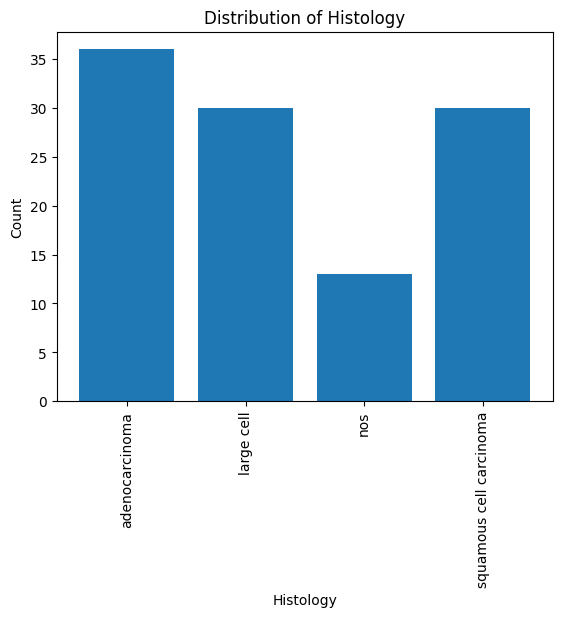

In [12]:
histology_counts = full_df.groupby('Histology').count()

# plot the counts for each histology as a bar chart
plt.bar(histology_counts.index, histology_counts.iloc[:,0])

# set the plot title and axis labels
plt.title('Distribution of Histology')
plt.xlabel('Histology')
plt.ylabel('Count')

plt.xticks(rotation=90)

# show the plot
plt.show()

In [13]:
full_df.head(10)


,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age,shape_original_shape_Compactness1,shape_original_shape_Compactness2,shape_original_shape_Maximum3DDiameter,...,textural_original_glrlm_LongRunEmphasis,textural_original_glrlm_GrayLevelNonUniformity,textural_original_glrlm_RunLengthNonUniformity,textural_original_glrlm_RunPercentage,textural_original_glrlm_LowGrayLevelRunEmphasis,textural_original_glrlm_HighGrayLevelRunEmphasis,textural_original_glrlm_ShortRunLowGrayLevelEmphasis,textural_original_glrlm_ShortRunHighGrayLevelEmphasis,textural_original_glrlm_LongRunLowGrayLevelEmphasis,textural_original_glrlm_LongRunHighGrayLevelEmphasis
0,13,nos,0,0,l1,4,44.3970,0.028885,0.296451,106.901824,...,5.786839,21219.447221,64776.697579,0.567095,0.001493,808.353957,0.001094,554.111998,0.007535,4654.031976
1,155,adenocarcinoma,0,3,l1,1,63.3183,0.031948,0.362660,18.814888,...,1.160397,25.291608,795.675280,0.953475,0.011646,548.964573,0.010836,529.644029,0.015633,639.621963
2,404,large cell,0,2,l1,2,64.7255,0.015999,0.090945,105.080921,...,4.064385,3225.808332,14007.509285,0.644247,0.001171,1600.952265,0.001003,1181.377774,0.003027,7156.937667
3,407,nos,0,0,l1,2,65.3635,0.031358,0.349373,46.968074,...,2.902586,1147.928170,6094.805584,0.711467,0.002104,1533.217788,0.001900,1182.876363,0.003685,4776.549408
4,9,adenocarcinoma,0,0,l2,2,50.0000,0.017815,0.112759,56.542020,...,1.195505,652.071367,15924.101510,0.942025,0.019281,344.205786,0.018221,331.901212,0.024175,400.015847
5,49,squamous cell carcinoma,0,0,l1,2,86.1410,0.038162,0.517446,20.124612,...,1.349145,42.677225,1322.447200,0.913117,0.012078,649.651998,0.011568,588.376279,0.014737,1049.436765
8,170,large cell,0,3,l1,1,69.8727,0.019293,0.132257,74.605630,...,2.299438,2048.787215,21459.338585,0.776105,0.002423,948.285325,0.002223,768.640615,0.003823,2588.351267
9,387,large cell,0,3,l1,2,52.8569,0.025315,0.227692,120.577776,...,5.859504,21540.882312,47685.570222,0.563663,0.000927,1414.067667,0.000699,930.825032,0.004220,8718.894943
10,319,adenocarcinoma,0,0,l2,1,77.0000,0.024706,0.216875,35.832946,...,1.258746,217.045222,4133.589709,0.925563,0.007384,321.677187,0.007016,305.147920,0.009095,397.643010
11,119,adenocarcinoma,0,0,l2,2,62.0000,0.023450,0.195381,39.673669,...,1.433416,248.806132,6839.484266,0.898177,0.006853,506.780756,0.006421,457.534076,0.008976,913.624084


We can see here that adenocarcinoma and squamous cell carcinoma are the most represented histologies in our data. This could potentially yield a bias in the data, so we can try to separate the data into these four types.

I made a pair plot using seaborn to condense some correlations down but also visualize them.

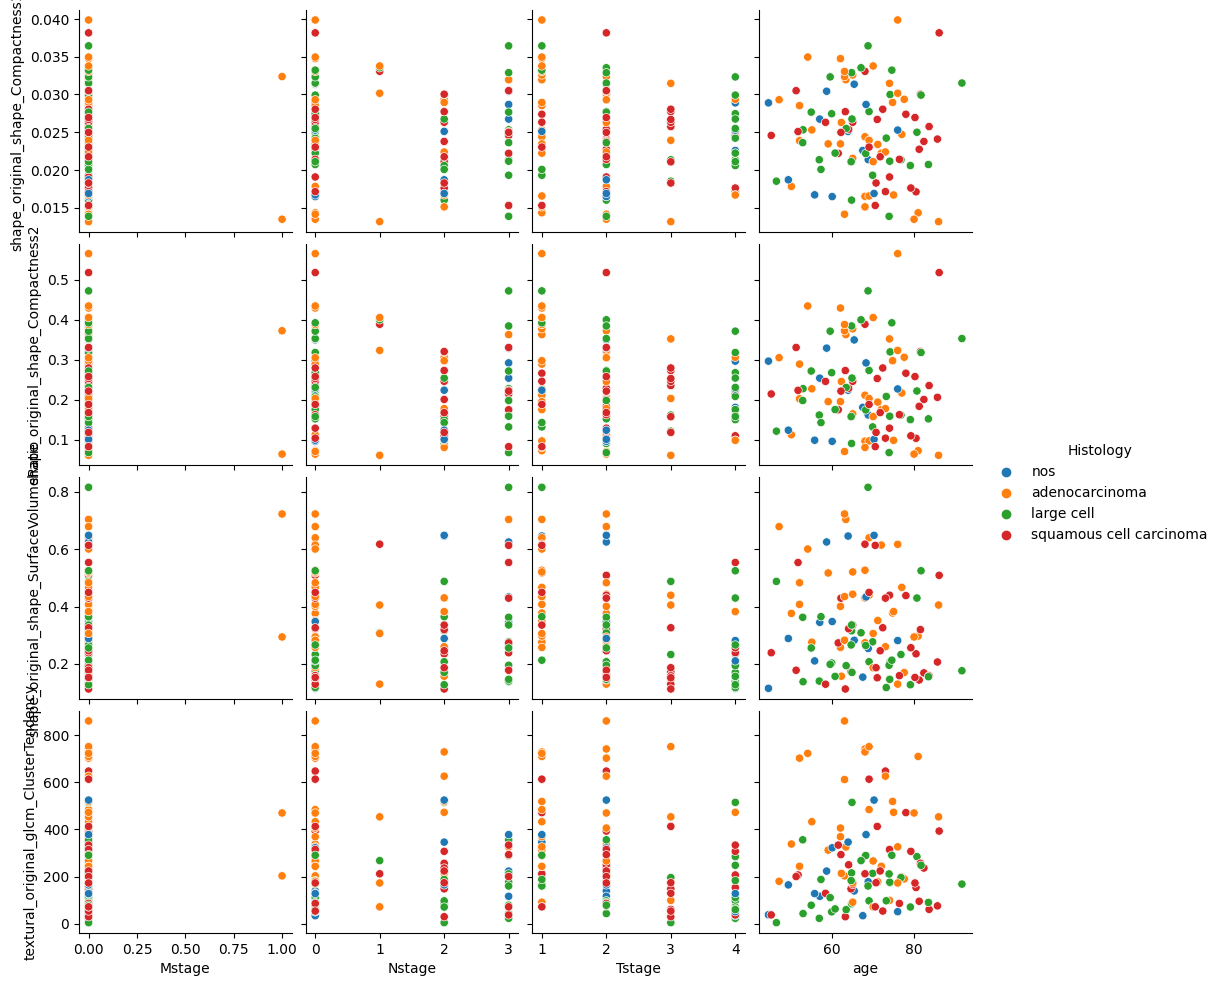

In [14]:
pairplot_cols = full_df[['Histology', 'Mstage', 'Nstage', 'Tstage', 'age', 'shape_original_shape_Compactness1', 'shape_original_shape_Compactness2', 'shape_original_shape_SurfaceVolumeRatio', 'textural_original_glcm_ClusterTendency']]
sb.pairplot(pairplot_cols, x_vars=['Mstage', 'Nstage', 'Tstage', 'age'], y_vars=['shape_original_shape_Compactness1', 'shape_original_shape_Compactness2', 'shape_original_shape_SurfaceVolumeRatio', 'textural_original_glcm_ClusterTendency'], hue='Histology')
plt.show()

Here are the variables in this plot:

- On the x-axis we have Mstage, Nstage, Tstage, and age.

- On the y-axis, we have shape_original_shape_Compactness1, shape_original_shape_Compactnesss2, shape_original_shape_SurfaceVolumeRatio, and textural_original_glcm_ClusterTendency.

What we notice from these plots is that the values compared with the different stage categorical variables are all over the place, being that the stage variables don't have many variables to compare to. We can say the same about age but looking at where all the points in the cluster areas lie, we can potentially see a positive correlation if we were to implement a line of best fit. I will do this in the next step.

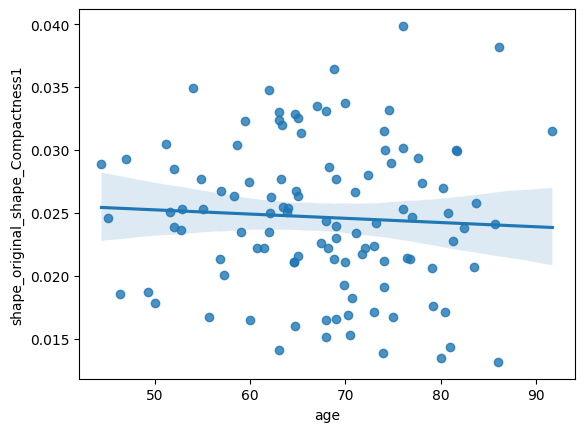

In [15]:
sb.regplot(x=full_df[['age']], y=full_df[['shape_original_shape_Compactness1']], data=full_df);

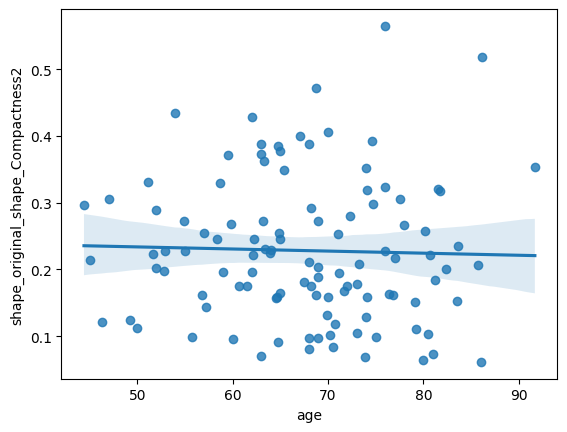

In [16]:
sb.regplot(x=full_df[['age']], y=full_df[['shape_original_shape_Compactness2']], data=full_df);

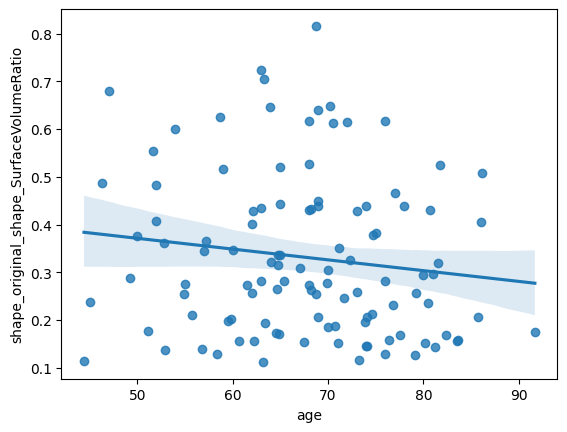

In [17]:
sb.regplot(x=full_df[['age']], y=full_df[['shape_original_shape_SurfaceVolumeRatio']], data=full_df);

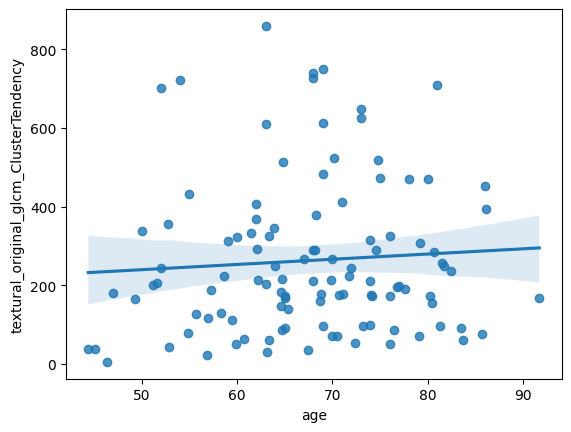

In [18]:
sb.regplot(x=full_df[['age']], y=full_df[['textural_original_glcm_ClusterTendency']], data=full_df);

The first three scatterplots have a flat line of best fit, meanwhile, the plot of age vs cluster tendency shows a slightly positive correlation. From this we can just gather that as the age of the cancer patient goes up, the cluster tendency may become more prevalent.

Here we just dropped columns that we do not need for predicting numeric values.

In [19]:
full_df = full_df.drop(['Histology','SourceDataset'], axis=1)
full_df.head(10)

,PatientID,Mstage,Nstage,Tstage,age,shape_original_shape_Compactness1,shape_original_shape_Compactness2,shape_original_shape_Maximum3DDiameter,shape_original_shape_SphericalDisproportion,shape_original_shape_Sphericity,...,textural_original_glrlm_LongRunEmphasis,textural_original_glrlm_GrayLevelNonUniformity,textural_original_glrlm_RunLengthNonUniformity,textural_original_glrlm_RunPercentage,textural_original_glrlm_LowGrayLevelRunEmphasis,textural_original_glrlm_HighGrayLevelRunEmphasis,textural_original_glrlm_ShortRunLowGrayLevelEmphasis,textural_original_glrlm_ShortRunHighGrayLevelEmphasis,textural_original_glrlm_LongRunLowGrayLevelEmphasis,textural_original_glrlm_LongRunHighGrayLevelEmphasis
0,13,0,0,4,44.3970,0.028885,0.296451,106.901824,1.499738,0.666783,...,5.786839,21219.447221,64776.697579,0.567095,0.001493,808.353957,0.001094,554.111998,0.007535,4654.031976
1,155,0,3,1,63.3183,0.031948,0.362660,18.814888,1.402276,0.713126,...,1.160397,25.291608,795.675280,0.953475,0.011646,548.964573,0.010836,529.644029,0.015633,639.621963
2,404,0,2,2,64.7255,0.015999,0.090945,105.080921,2.223687,0.449704,...,4.064385,3225.808332,14007.509285,0.644247,0.001171,1600.952265,0.001003,1181.377774,0.003027,7156.937667
3,407,0,0,2,65.3635,0.031358,0.349373,46.968074,1.419832,0.704309,...,2.902586,1147.928170,6094.805584,0.711467,0.002104,1533.217788,0.001900,1182.876363,0.003685,4776.549408
4,9,0,0,2,50.0000,0.017815,0.112759,56.542020,2.069901,0.483115,...,1.195505,652.071367,15924.101510,0.942025,0.019281,344.205786,0.018221,331.901212,0.024175,400.015847
5,49,0,0,2,86.1410,0.038162,0.517446,20.124612,1.245599,0.802826,...,1.349145,42.677225,1322.447200,0.913117,0.012078,649.651998,0.011568,588.376279,0.014737,1049.436765
8,170,0,3,1,69.8727,0.019293,0.132257,74.605630,1.962732,0.509494,...,2.299438,2048.787215,21459.338585,0.776105,0.002423,948.285325,0.002223,768.640615,0.003823,2588.351267
9,387,0,3,2,52.8569,0.025315,0.227692,120.577776,1.637636,0.610636,...,5.859504,21540.882312,47685.570222,0.563663,0.000927,1414.067667,0.000699,930.825032,0.004220,8718.894943
10,319,0,0,1,77.0000,0.024706,0.216875,35.832946,1.664421,0.600809,...,1.258746,217.045222,4133.589709,0.925563,0.007384,321.677187,0.007016,305.147920,0.009095,397.643010
11,119,0,0,2,62.0000,0.023450,0.195381,39.673669,1.723347,0.580266,...,1.433416,248.806132,6839.484266,0.898177,0.006853,506.780756,0.006421,457.534076,0.008976,913.624084


In [20]:
full_df.to_csv('x test(9c)/test_full_df.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ff46915c-5d98-4aea-b947-cb4657d60849' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>